# Second order hypothesis testing

In [1]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [2]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [3]:
import os
import torch
import imp

import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from scvi.dataset import CortexDataset, RetinaDataset, PbmcDataset
from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.metrics.differential_expression import de_stats
from scvi.metrics.imputation import imputation
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

from scvi_extensions.inference.supervised_variational_inference import SupervisedVariationalInference

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import scvi_extensions.hypothesis_testing.utils as utils
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

### Load data

In [5]:
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1_default.norm.meta.txt'

In [6]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='gene',
    testing_labels='gene',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


### Load the model

In [7]:
model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes_kogene.model', map_location=lambda storage, loc: storage)

/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Variance testing

Variance should decrease for ENO1 and variance should increase for BATF.

In [15]:
imp.reload(utils)
imp.reload(vr)

<module 'scvi_extensions.hypothesis_testing.variance' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/hypothesis_testing/variance.py'>

In [16]:
genes_of_interest = ['BATF', 'ENO1', 'NO_GUIDE']

In [17]:
for gene in genes_of_interest:
    print(gene, np.where(gene_dataset.ko_gene_lookup == gene)[0][0])

BATF 8
ENO1 29
NO_GUIDE 78


In [58]:
M_sampling=1000

In [ ]:
imp.reload(vr)
null_rates, var_test_results = vr.gene_variance_test(model, gene_dataset, [8, 29, 78], M_sampling)

Sampling for variance testing...


In [ ]:
var_test_results[8][78].query('gene == "BATF"')

In [ ]:
var_test_results[29][78].query('gene == "ENO1"')

### Explore these genes more with explicit sampling distribution of the Bayes factors

In [15]:
imp.reload(vr)
batf_h1_bfs, batf_h0_bfs = vr.batch_variance_test(
    model, 
    gene_dataset,
    desired_labels=[8, 78],
    M_sampling=100)

In [38]:
imp.reload(vr)
eno1_h1_bfs, eno1_h0_bfs = vr.batch_variance_test(
    model, 
    gene_dataset,
    desired_labels=[29, 78],
    M_sampling=100)

In [10]:
batf_h1_bfs.shape

(79, 1000)

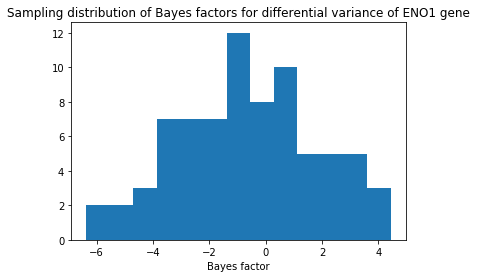

In [51]:
plt.hist(eno1_h1_bfs[:,135][np.absolute(eno1_h1_bfs[:,135]) < 10], bins=13);
plt.title('Sampling distribution of BFs for differential variance of ENO1 gene');
plt.xlabel('Bayes factor');
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/eno1_sampling_distribution.png', bbox='tight')

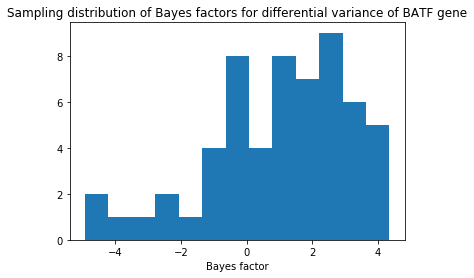

In [52]:
plt.hist(batf_h1_bfs[:,826][np.absolute(batf_h1_bfs[:,826]) < 5], bins=13);
plt.title('Sampling distribution of BFs for differential variance of BATF gene');
plt.xlabel('Bayes factor');
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/batf_sampling_distribution.png', bbox='tight')